In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tqdm
import seaborn as sns

from tensorflow import keras
from keras import Input, Model, Sequential
from tensorflow.keras.regularizers import l2
from keras.layers import Dense, Flatten, InputLayer, Reshape, BatchNormalization, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model

%matplotlib inline

In [3]:
# Dict of labels
categories = {
                'Abbas': 0,
                'Ijaz': 1,
                'Saeed': 2,
                           }
print(categories)                           

{'Abbas': 0, 'Ijaz': 1, 'Saeed': 2}


#Load Data

In [5]:
def load_images(images_folder, img_size = (256, 256), scale=False):

    # Store paths to images
    image_path = []
    for dirname, _, filenames in os.walk(images_folder):
        for filename in filenames:
            image_path.append(os.path.join(dirname, filename))

    print("There are {} images in {}".format(len(image_path), images_folder))
    
    # Load images and associated labels
    images = []
    labels = []

    for path in tqdm.tqdm(image_path):

        img = cv2.imread(path)    
        img = cv2.resize(img, img_size) # Resize the images

        img = np.array(img)

        images.append(img)
        labels.append(categories[path.split('/')[-2]]) # last folder before the image name is the category

    images = np.array(images)  
    images = images.astype(np.int64)
    
    if scale:
        images = images/255 # scale
        
    return image_path, images, np.asarray(labels)

In [6]:
main = '/content/drive/MyDrive/Face Classification datasets/Train'
second= '/content/drive/MyDrive/Face Classification datasets/Train'
img_size = (256, 256)
#/media/zaka/A86687076686D60A/vscode_workspace/Cats-and-Dogs-classification-master/correct-dataset
#images_folder = os.path.join('/', 'kaggle', 'input', 'satellite-image-classification', 'data')
images_folder = os.path.join('/content/drive/MyDrive/Face Classification datasets/Train')
image_path, images, labels = load_images(images_folder, img_size=img_size)

# Resize
# images = np.array(images).reshape(-1,256,256,1)
images.shape

There are 891 images in /content/drive/MyDrive/Face Classification datasets/Train


100%|██████████| 891/891 [06:21<00:00,  2.33it/s]


(891, 256, 256, 3)

In [7]:
set(labels)

{0, 1, 2}

#Visualizing

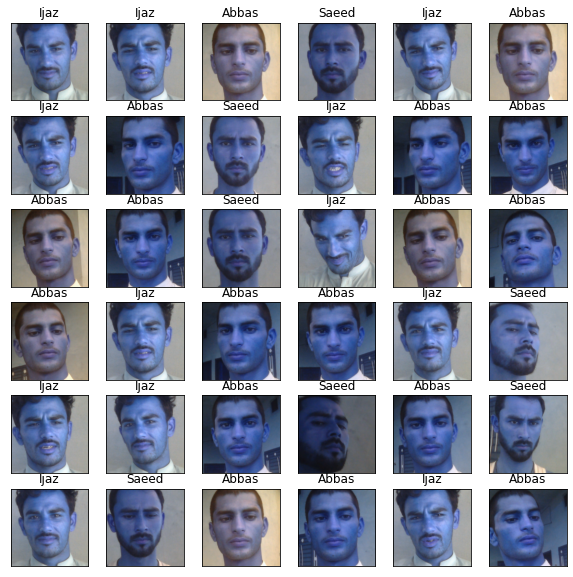

In [8]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(len(image_path),36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(images[image_ind]), cmap=plt.cm.binary)
    
    label = list(categories.keys())[list(categories.values()).index(labels[image_ind])]
    plt.title(label)

#How are the categories distributed?

In [9]:
labels_df = pd.DataFrame(labels) 
labels_df.value_counts()

0    297
1    297
2    297
dtype: int64

#Model building

In [10]:
len(categories)

3

In [11]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization

def build_cnn_model():
    cnn_model=tf.keras.Sequential([
      Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=images.shape[1:]),
      MaxPooling2D(2,2),
      BatchNormalization(),
      Dropout(0.4),

      Conv2D(filters=64,kernel_size=(3,3),activation='relu', padding='same'),
      Conv2D(filters=64,kernel_size=(3,3),activation='relu', padding='same'),
      MaxPooling2D((2,2)),
      BatchNormalization(),
      Dropout(0.4),

      Conv2D(filters=128,kernel_size=(3,3),activation='relu', padding='same'),
      Conv2D(filters=128,kernel_size=(3,3),activation='relu', padding='same'),
      MaxPooling2D(2,2),
      BatchNormalization(),
      Dropout(0.4),
        
      Conv2D(filters=256,kernel_size=(3,3),activation='relu', padding='same'),
      Conv2D(filters=256,kernel_size=(3,3),activation='relu', padding='same'),
      MaxPooling2D(2,2),
      BatchNormalization(),
      Dropout(0.4),
        

      Conv2D(filters=128,kernel_size=(3,3),activation='relu', padding='same'),
      Conv2D(filters=128,kernel_size=(3,3),activation='relu', padding='same'),
      MaxPooling2D(2,2),
      BatchNormalization(),
      Dropout(0.4),
        
      Conv2D(filters=64,kernel_size=(3,3),activation='relu', padding='same'),
      Conv2D(filters=64,kernel_size=(3,3),activation='relu', padding='same'),
      MaxPooling2D((2,2)),
      BatchNormalization(),
      Dropout(0.4),

      Flatten(),

      Dense(units=len(categories),activation='softmax')
    ])

    return cnn_model
  
model = build_cnn_model()
# Initialize the model by passing some data through
model.predict(images[[0]])
# Print the summary of the layers in the model.
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 32)     128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 127, 127, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 127, 127, 64)      3

#Plot the model

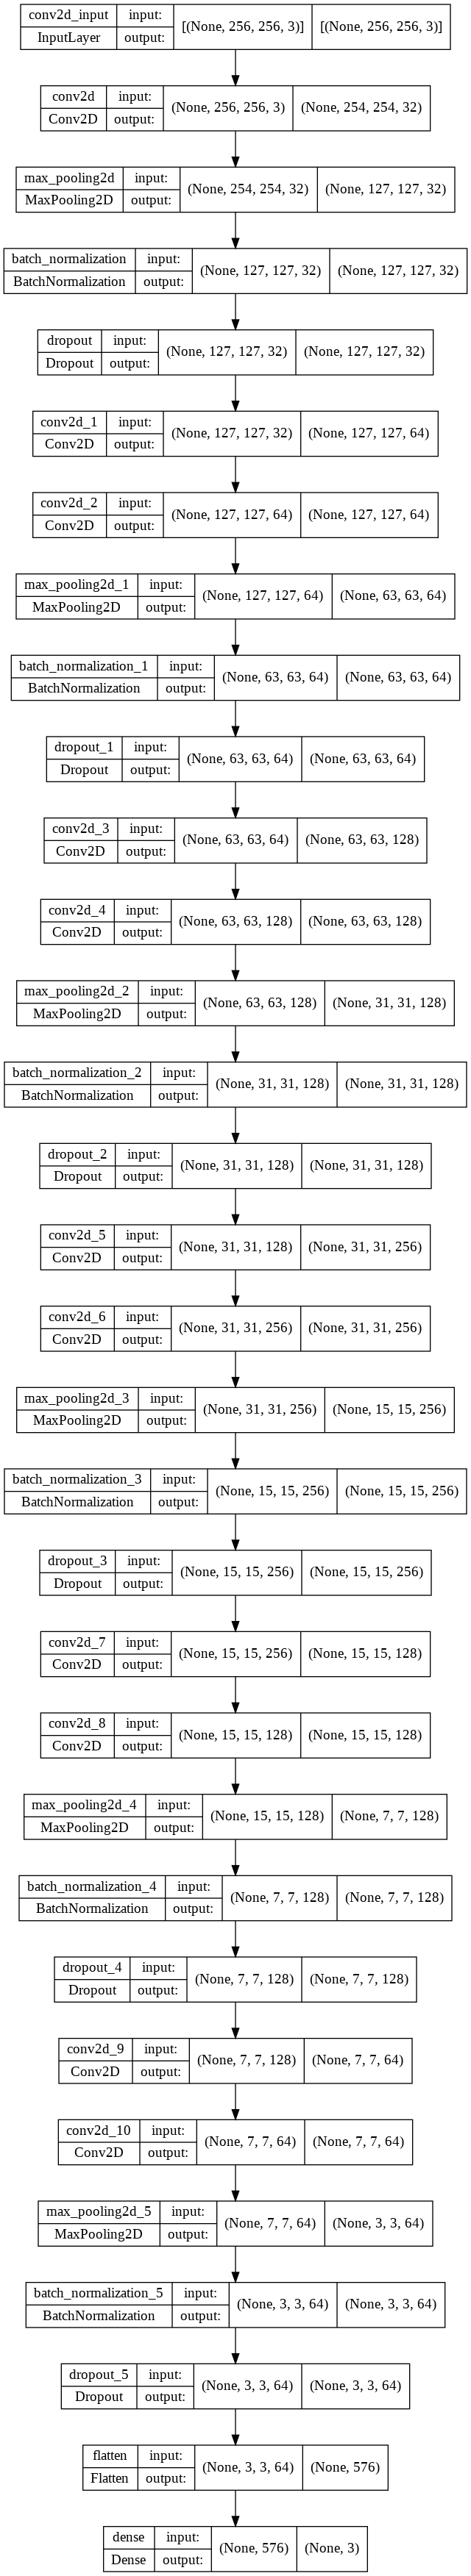

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [16]:
labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

#Convert labels to categorical

In [17]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = to_categorical(labels)
labels[:10]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [18]:
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [19]:
print(images.shape)
print(labels.shape)

(891, 256, 256, 3)
(891, 3)


#Split the data

In [20]:
from sklearn.model_selection import train_test_split
# Train, validation and test split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=7)

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=1) 

In [21]:
print("*-*-*-*-*-*")
print("Train")
print(X_train.shape)
print(y_train.shape)

'''
print("*-*-*-*-*-*")
print("Validation")
print(X_val.shape)
print(y_val.shape)
'''

print("*-*-*-*-*-*")
print("Test")
print(X_test.shape)
print(y_test.shape)

*-*-*-*-*-*
Train
(712, 256, 256, 3)
(712, 3)
*-*-*-*-*-*
Test
(179, 256, 256, 3)
(179, 3)


#Model training

In [22]:
y_train[0]

array([1., 0., 0.], dtype=float32)

In [23]:
history = model.fit(X_train, y_train, 
                    batch_size = 20, 
                    epochs = 30, 
                   )

Epoch 1/30
36/36 [==============================] - 11s 169ms/step - loss: 0.3451 - accuracy: 0.8750
Epoch 2/30
36/36 [==============================] - 4s 107ms/step - loss: 0.0545 - accuracy: 0.9803
Epoch 3/30
36/36 [==============================] - 4s 108ms/step - loss: 0.0204 - accuracy: 0.9958
Epoch 4/30
36/36 [==============================] - 4s 109ms/step - loss: 0.0220 - accuracy: 0.9944
Epoch 5/30
36/36 [==============================] - 4s 109ms/step - loss: 0.0284 - accuracy: 0.9930
Epoch 6/30
36/36 [==============================] - 4s 108ms/step - loss: 0.0243 - accuracy: 0.9916
Epoch 7/30
36/36 [==============================] - 4s 107ms/step - loss: 0.0058 - accuracy: 0.9986
Epoch 8/30
36/36 [==============================] - 4s 106ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 9/30
36/36 [==============================] - 4s 106ms/step - loss: 4.7625e-04 - accuracy: 1.0000
Epoch 10/30
36/36 [==============================] - 4s 106ms/step - loss: 3.8378e-04 - accurac

In [25]:
model.evaluate(X_test, y_test)

6/6 [==============================] - 4s 352ms/step - loss: 0.1751 - accuracy: 0.9385


[0.17512011528015137, 0.9385474920272827]

In [26]:
model.save('face_classification.h5')

In [67]:
# Predict on test set
y_pred = model.predict(X_test)

In [68]:
y_pred = model.predict(X_test, verbose=0)
y_pred.shape

(179, 3)

In [69]:
from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

In [70]:
c_matrix

array([[42, 11,  0],
       [ 0, 60,  0],
       [ 0,  0, 66]])

In [71]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

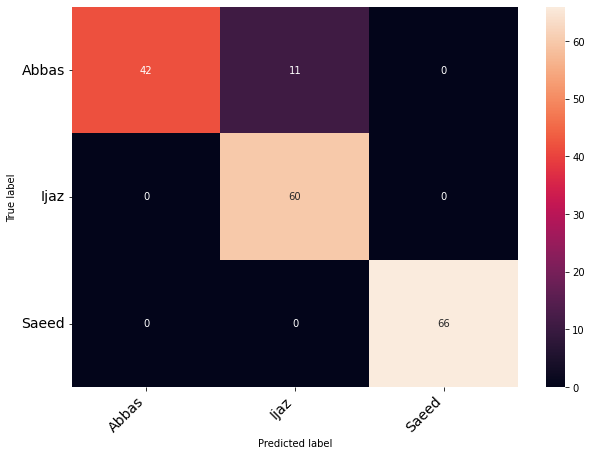

In [73]:

confusion_matrix(c_matrix, categories, figsize = (10,7), fontsize=14)

In [74]:
# From categorical outputs to discrete values

y_pred_ = [np.argmax(y) for y in y_pred]
y_test_ = [np.argmax(y) for y in y_test]

In [75]:
from sklearn.metrics import classification_report
print(classification_report(y_test_, y_pred_))

              precision    recall  f1-score   support

           0       1.00      0.79      0.88        53
           1       0.85      1.00      0.92        60
           2       1.00      1.00      1.00        66

    accuracy                           0.94       179
   macro avg       0.95      0.93      0.93       179
weighted avg       0.95      0.94      0.94       179



#Predict on new data

In [48]:
def predict_class(img):
    # Resize
    img = img.reshape(1,256,256,3)
    # Predict
    predictions = model.predict(img)
    true_prediction = [tf.argmax(pred) for pred in predictions]
    true_prediction = np.array(true_prediction)
    
    # Return label corresponding to predicted index
    return list(categories.keys())[list(categories.values()).index(true_prediction)]
    

In [57]:
predict_class(X_test[0])

'Saeed'

#Display and Predict

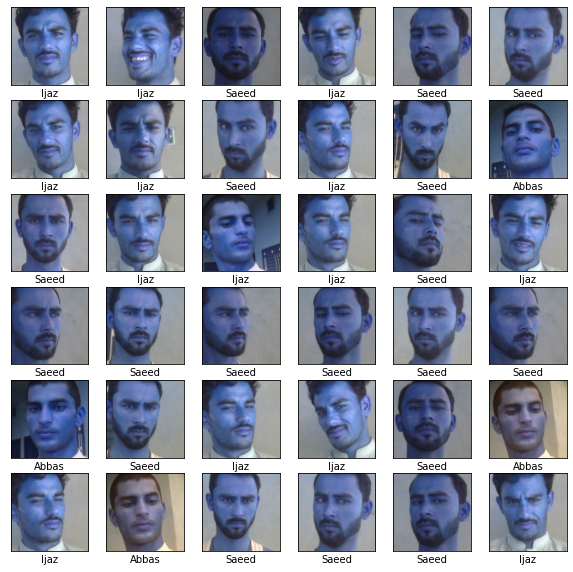

In [76]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(X_test.shape[0],36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(X_test[image_ind]), cmap=plt.cm.binary)
    
    # Predict and get label
    label = predict_class(X_test[image_ind])
    plt.xlabel(label)